In [11]:
from PyCkt import PyCkt
import tensorflow as tf
import numpy as np
import math

In [12]:
# helper functions for measuring fault coverage
def bin2dec(bin_nb):
    """converts binary no string to uint"""
    
    return int(bin_nb, 2)
    

def update_part_counts():
    """updates number of observed counts for all partititions in the response"""

    global obs_value_counts, obs_values
    for observation in observations:
        for i in range(num_p):
            #extract window substring
            substr = observation[ i*partition_size : min(len(observation),
                                                         (i+1)*partition_size) ]

            #get count index from the observed number in the window (i.e. substring)
            c_ind = bin2dec(substr)

            #increment observation count of the observed number
            obs_value_counts[i][c_ind]+=1

            #add to observed numbers if not observed before
            if c_ind not in obs_values[i]:
                obs_values[i].append(c_ind)

def get_updated_metrics(resp_ind):
    """updates the metrics according to the response and reports them"""

    #tracks count of numbers observed so far in each window
    num_obs = [0 for _ in range(num_p)] 

    #tracks cumulative entropy observed so far
    cum_ent = [0. for _ in range(num_p)]

    update_part_counts()

    for i in range(num_p):
        num_obs[i] = len(obs_values[i])
        ent = 0.
        for j in range(max_obs):
            pj = obs_value_counts[i][j] * 1.0 / (resp_ind + 1)
            if pj != 0:
                 ent = ent + pj * math.log(pj,2)
        cum_ent[i] = ent

    # concatenate all features together
    metrics = num_obs + cum_ent
    metrics = list(map(lambda x: abs(x), metrics))

    #return selected metrics only
    sel_mets = []
    for j in range(len(metrics)):
        if j in sel_indices:
            sel_mets.append(metrics[j])

    return sel_mets

def get_est_fcov(resp_ind):
    """returns new estimated fault coverage from circuit outputs"""

    #get values of selected features
    sel_feat = get_updated_metrics(resp_ind)
    return np.dot(sel_feat, coeff) + intrc

In [13]:
# interface adapters
def preprocess_observation(observations):
    """converts observation from string to list"""
    
    ar_ = []
    for observation in observations:
        for c_ in observation:
            if c_ == '1':
                ar_.append(1)
            else:
                ar_.append(0)
    return ar_

def encode_vec(vlist):
    """converts vector from list to string"""
    
    s = ''
    for e in vlist:
        if e==1:
            s = s + '1'
        else:
            s = s + '0'
    return s.encode()

In [14]:
# agent helper functions
def choose_action(probability):
    """returns an action given the probability of 1"""
    
    random_value = np.random.uniform()
    if random_value < probability:
        return 1
    else:
        return 0

def discount_rewards(rewards, gamma):
    """ In a sequential system the actions you take 20 steps before the end result are more important to the 
    overall result than an action you took one step ago. Note that gamma gets multiplied the most with the 
    latest action and least with the first action"""
    
    discounted_rewards = np.zeros_like(rewards)
    
    # running_add is the accumulators of the discounted rewards
    running_add = 0
    for t in reversed(range(0, rewards.size)):
        running_add = running_add * gamma + rewards[t]
        discounted_rewards[t] = running_add
    
    discounted_rewards -= np.mean(discounted_rewards)
    discounted_rewards /= (np.std(discounted_rewards) + 1e-10)
    
    return discounted_rewards

In [15]:
class PolicyGradientAgent:
    
    def __init__(self, hparams, sess):
        
        # initialization
        self._s = sess
        
        # build the graph
        # forward path
        self._input = tf.placeholder(tf.float32,
                                    shape = [None, hparams['input_size']])
        
        hidden = []
        for layer_nb in range(len(hparams['nn_conf'])):
            if layer_nb == 0:
                layer_inp = self._input
            else:
                layer_inp = hidden[layer_nb-1]
            hidden.append(tf.contrib.layers.fully_connected(
                    inputs = layer_inp,
                    num_outputs = hparams['nn_conf'][layer_nb],
                    activation_fn = tf.nn.relu,
                    weights_initializer = tf.contrib.layers.xavier_initializer()))

        self._up_prob = tf.contrib.layers.fully_connected(
                inputs = hidden[-1],
                num_outputs = hparams['num_actions'],
                activation_fn = tf.nn.softmax)
        
        
        # backward path (training)
        tvars = tf.trainable_variables()
        self._tvars = tvars
        self._actions = tf.placeholder(tf.float32, 
                        shape = [None, hparams['num_actions']])
        self._rewards = tf.placeholder(tf.float32, 
                        shape = [None, 1])
        
        log_prob = tf.log(self._up_prob)
        log_prob_compl = tf.log(1. - self._up_prob)
        
        #log_likelihood = self._actions * (self._actions - self._up_prob) + \
        #(1 - self._actions) * (self._actions + self._up_prob)
        
        step_losses = self._actions * log_prob + \
        (1 - self._actions) * log_prob_compl
        #loss = tf.reduce_sum(log_likelihood * self._rewards)
        loss = -tf.reduce_sum(step_losses * self._rewards)
        self._gradients = tf.gradients(loss, tvars)
        
        # nn update
        #optimizer = tf.train.RMSPropOptimizer(hparams['learning_rate'],
        #                                     hparams['decay_rate'])
        
        optimizer = tf.train.AdamOptimizer(hparams['learning_rate'])
        
        self._modified_gradients = []
        for var_ind in range(len(tvars)):
            self._modified_gradients.append(tf.placeholder(tf.float32))
            
        self._update_grads = optimizer.apply_gradients(zip(self._modified_gradients,
                                     tvars))
     
        
    def act(self, observation):
        """get the actions (vector) by sampling"""
        
        return self._s.run(self._up_prob,
                            feed_dict={self._input: [observation]})
    
    def get_gradients(self, obs, acts, rewards):
        """computes and returns the gradients"""
        batch_feed = {self._input: obs,
                     self._actions: acts,
                     self._rewards: rewards}
        return self._s.run(self._gradients, feed_dict = batch_feed)
        
    def apply_grads(self, gradient_buffer):
        """batch applies the modified gradients"""
        batch_feed = {}
        for ind, item in enumerate(gradient_buffer):
            batch_feed[self._modified_gradients[ind]] = item
        self._s.run(self._update_grads, feed_dict = batch_feed)
        
    def get_tvars(self):
        return self._tvars
        
        
    

In [16]:
def policy_rollout(ckt, agent):
    """run one episode"""
    
    # episode interface containers
    episode_observations = []
    episode_actions = []
    episode_rewards = []
    
    # reset the containers that hold the environment measurements internally
    num_applied_vecs = 0
    global obs_values, obs_value_counts, fcov, max_reward_sum, best_actions
    obs_values = [[] for w in range(num_p)]
    
    obs_value_counts = [[0 for i in range(max_obs)] for w in range(num_p)]
    
    # initialize ckt
    ckt.reset()
    global observations
    observations = []
    for vec in init_seq:
        resp, state = ckt.lsim_s(vec.encode())
    observations.append((resp + state).decode())

    # post apply random vectors to the initialization sequence
    # to complete the vector per particle count vpp
    for vec_ind in range(vpp - 1):
        #print ('appending %d random vecs to init sequence' % (vpp-1))
        vec = [np.random.randint(0,1) for _ in range(veclen)]
        resp, state = ckt.lsim_s(encode_vec(vec))
        observations.append((resp + state).decode())
        num_applied_vecs += 1

    # we sample cumulative reward after every vpp vectors
    prev_reward_sum = 0
    reward_sum = get_est_fcov(num_applied_vecs)
    
    while num_applied_vecs < max_vecs:
        # convert list of strings to a flattened list of integers
        processed_observations = preprocess_observation(observations)
        episode_observations.append(processed_observations)
        
        # an action is a flattened set of vpp vectors
        prob = (agent.act(processed_observations)).ravel()
        action = list(map(lambda x: choose_action(x), prob))
        episode_actions.append(action)
        
        observations = []
        
        # carry out the sampled action i.e.
        # extract vpp vectors and apply them to ckt
        for vec_ind in range(vpp):
            lb = vec_ind * veclen
            ub = (vec_ind + 1) * veclen
            vec = action[lb:ub]
            resp, state = ckt.lsim_s(encode_vec(vec))
            observations.append((resp+state).decode())
            num_applied_vecs += 1

        prev_reward_sum = reward_sum
        reward_sum = get_est_fcov(num_applied_vecs)
        
        
        # reward to an action is obtained from cumulative reward
        reward = reward_sum - prev_reward_sum
        episode_rewards.append(reward)
    
    print ('episode reward total was %f' % reward_sum)
    if reward_sum > max_reward_sum:
        max_reward_sum = reward_sum
        best_actions = episode_actions
    f_cov.append(reward_sum)
    # print ('applied vecs %f' % num_applied_vecs)
    # return the summary of the episode
    return np.vstack(episode_observations), np.vstack(episode_actions), \
    np.vstack(episode_rewards)
    

In [17]:
# define circuit parameters
f_cov = []
cktname = 's820'
coeff = [0.02586818,  0.01588013, -0.16383635, -0.09241966, 0.08055655, 0.0037864, 0.23622088, 0.12172977]
intrc = 0.05043711182
feature_indices = [11, 12, 15, 18, 19, 20, 23, 24]
sel_indices = list(map(lambda x: x - 1, feature_indices))
init_seq = ['010100011011011001','101011010110110110']
partition_size = 2
max_obs = 2**partition_size
max_vecs = 700
vpp = 1
observations = []

# define agent parameters
nn_conf = [200]
gamma = 0.8
num_batches = 10000
episodes_per_batch = 1
learning_rate = 5e-4
decay_rate = 0.99

# create circuit instance and get internal info
ckt = PyCkt(cktname.encode())
input_dimensions = vpp * (ckt.getNumPo() + ckt.getNumState())
veclen = ckt.getNumPi()
statelen = ckt.getNumPo() + ckt.getNumState()
output_dimensions = vpp * veclen
num_p = math.ceil(statelen / partition_size)
max_reward_sum = 0
best_actions = []

# hyperparameters
hparams = {
    'input_size': input_dimensions,
    'nn_conf': nn_conf,
    'num_actions': output_dimensions,
    'learning_rate': learning_rate,
    'decay_rate': decay_rate
}

# environment parameters
eparams = {
    'num_batches': num_batches,
    'ep_per_batch': episodes_per_batch
}

with tf.Graph().as_default(), tf.Session() as sess:
    agent = PolicyGradientAgent(hparams, sess)
    sess.run(tf.global_variables_initializer())
    
    g_dict = sess.run(agent.get_tvars())
    #print (g_dict)
    for ind, grad in enumerate(g_dict):
        g_dict[ind] = grad * 0.
    print (type(g_dict), len(g_dict))
    
    for batch in range(eparams['num_batches']):
     
        for _ in range(eparams['ep_per_batch']):
            
            obs, acts, rews = policy_rollout(ckt, agent)
            rews = discount_rewards(rews, gamma)
            grads = agent.get_gradients(obs, acts, rews)
            
            for ind, grad in enumerate(grads):
                g_dict[ind] += grad
        
        agent.apply_grads(g_dict)
    print (max_reward_sum)
        

<class 'list'> 4
episode reward total was 0.360034
episode reward total was 0.386981
episode reward total was 0.371297
episode reward total was 0.381237
episode reward total was 0.393319
episode reward total was 0.382590
episode reward total was 0.381702
episode reward total was 0.381906
episode reward total was 0.393652
episode reward total was 0.372615
episode reward total was 0.374328
episode reward total was 0.392733
episode reward total was 0.373352
episode reward total was 0.386388
episode reward total was 0.404622
episode reward total was 0.379067
episode reward total was 0.390186
episode reward total was 0.389051
episode reward total was 0.405400
episode reward total was 0.396341
episode reward total was 0.395210
episode reward total was 0.415123
episode reward total was 0.402318
episode reward total was 0.400709
episode reward total was 0.384952
episode reward total was 0.414015
episode reward total was 0.391562
episode reward total was 0.398636
episode reward total was 0.4183

episode reward total was 0.628297
episode reward total was 0.623612
episode reward total was 0.626316
episode reward total was 0.625379
episode reward total was 0.633328
episode reward total was 0.634289
episode reward total was 0.631791
episode reward total was 0.632978
episode reward total was 0.630644
episode reward total was 0.636093
episode reward total was 0.635131
episode reward total was 0.633266
episode reward total was 0.634644
episode reward total was 0.633708
episode reward total was 0.635903
episode reward total was 0.634737
episode reward total was 0.633140
episode reward total was 0.634880
episode reward total was 0.631058
episode reward total was 0.633553
episode reward total was 0.635072
episode reward total was 0.633992
episode reward total was 0.632259
episode reward total was 0.634532
episode reward total was 0.633910
episode reward total was 0.634227
episode reward total was 0.633923
episode reward total was 0.632960
episode reward total was 0.634114
episode reward

KeyboardInterrupt: 

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

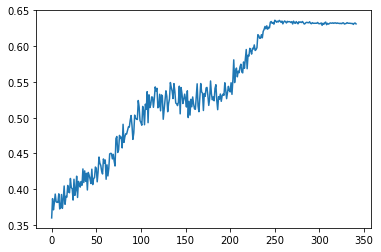

In [19]:
plt.plot(f_cov)

In [ ]:
i